In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal,stats,interpolate
from biosppy.signals import ecg,resp,eda,eeg
from multiprocessing import Pool
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import log_loss,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import random

In [2]:
def reduce_mem_usage(df):
    # Function to reduce memory usage of a pandas dataframe
    # https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    return df

### Reading train data

In [3]:
X_train = pd.read_parquet("train_new_features.gzip")
X_train.head()

,seat,time,ecg,r,heart_rate,heart_rate_diff,resp_rate,resp_rate_diff,gsr,gsr_diff,...,event,crew_1,crew_2,crew_3,crew_4,crew_5,crew_6,crew_7,crew_8,crew_13
0,1,0.011719,-4520.0,817.705994,-275.059326,0.000000,0.631937,0.000000,388.829987,0.0,...,0,1,0,0,0,0,0,0,0,0
1,1,0.015625,-4520.0,817.705994,-273.924194,1.135131,0.631433,-0.000504,388.829987,0.0,...,0,1,0,0,0,0,0,0,0,0
2,1,0.019531,-4520.0,817.705994,-272.791473,1.132734,0.630930,-0.000503,388.829987,0.0,...,0,1,0,0,0,0,0,0,0,0
3,1,0.023438,-4520.0,817.705994,-271.661133,1.130339,0.630426,-0.000503,388.829987,0.0,...,0,1,0,0,0,0,0,0,0,0
4,1,0.027344,-4520.0,817.705994,-270.533203,1.127947,0.629923,-0.000503,388.829987,0.0,...,0,1,0,0,0,0,0,0,0,0


In [4]:
X_train = reduce_mem_usage(X_train)
y_train = X_train['event']
X_train.drop(['event'], axis=1, inplace=True)
features = X_train.columns

#Splitting data into train and cv
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,stratify=y_train, test_size=0.2)
crew_ohe = pickle.load(open('crew_ohe.sav','rb'))
crew_ohe_features = ["crew_"+str(i) for i in crew_ohe.categories_[0]]
numerical_features = [feature for feature in features if feature not in crew_ohe_features+['seat']]

# Normalization
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_cv[numerical_features] = scaler.transform(X_cv[numerical_features])
pickle.dump(scaler, open('scaler.sav','wb'))

# Computing class weight
cw = compute_class_weight(class_weight='balanced', classes=[0,1,2,3], y=y_train.values)
cw = {k:v for k,v in enumerate(cw)}

In [5]:
def plot_confusion_matrix(test_y, predict_y):
    # Function to plot confusion matrix along with precision and recall matrix
    C = confusion_matrix(test_y, predict_y)
    print("Percentage of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0,1,2,3]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in recall matrix",A.sum(axis=1))

### Custom stacking classifier

In [6]:
class CustomStackingClassifier():
    def __init__(self, base_model_combination, meta_clf):
        self.layer1 = []
        # Base model combination is a list of tuples with the type of model and the number of models for each type
        for combination in base_model_combination:
            for i in range(combination[1]):
                self.layer1.append(combination[0])
        self.layer2 = meta_clf
    
    def fit_layer1(self, X, y, sample_size, class_weight):
        # Function to train base learners of stacking classifier
        X['event'] = y
        weights = y.map(lambda x: class_weight[x])
        weights = weights/sum(weights)
        samples = [X.sample(frac = sample_size, replace=True, weights=weights, random_state=33, axis=0) for i in range(len(self.layer1))]
        for i in range(len(self.layer1)):
            y_sample = samples[i]['event']
            X_sample = samples[i].drop(['event'], axis=1)
            self.layer1[i].fit(X_sample,y_sample)
    
    def fit_layer2(self, X, y):
        # Function to train meta classifier from the predictions of first layer and the actual output
        layer1_pred = pd.DataFrame()
        for i in range(len(self.layer1)):
            pred = self.layer1[i].predict(X)
            layer1_pred["model_"+str(i)] = pred
        self.layer2.fit(layer1_pred, y)
    
    def predict_proba(self, X):
        layer1_pred = pd.DataFrame()
        for i in range(len(self.layer1)):
            pred = self.layer1[i].predict(X)
            layer1_pred["model_"+str(i)] = pred
        return self.layer2.predict_proba(layer1_pred)
    
    def predict(self, X):
        layer1_pred = pd.DataFrame()
        for i in range(len(self.layer1)):
            pred = self.layer1[i].predict(X)
            layer1_pred["model_"+str(i)] = pred
        return self.layer2.predict(layer1_pred)

In [7]:
#Base models
nb_clf = GaussianNB(var_smoothing=1e-21)
r_clf=RandomForestClassifier(random_state=33, n_jobs=-1)
xgb_clf = XGBClassifier(n_jobs=-1, random_state=33)
lgb_clf = lgb.LGBMClassifier(boosting_type='goss',objective='multiclass',num_classes=4, random_state=33)

# After trying out various combinations, these were the base models which were found to give the best result
base_model_combination = [(nb_clf, 10),
                          (r_clf, 1),
                          (xgb_clf, 1),
                          (lgb_clf, 1)]
meta_clf = LogisticRegression(penalty='l2',class_weight=cw, n_jobs=-1)

### Training the model

In [8]:
stacking_clf = CustomStackingClassifier(base_model_combination, meta_clf)
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train,y_train,stratify=y_train, test_size=0.5)
stacking_clf.fit_layer1(X_train_1, y_train_1, sample_size=0.5, class_weight=cw)
stacking_clf.fit_layer2(X_train_2, y_train_2)
y_pred = stacking_clf.predict_proba(X_train)
loss = log_loss(y_train, y_pred)
print('Train log loss for custom stacking classifier is',loss)
y_pred = stacking_clf.predict_proba(X_cv)
loss = log_loss(y_cv, y_pred)
print('Cross validation log loss is',loss)
pickle.dump(stacking_clf, open('stacking_model.sav', 'wb'))

Train log loss for custom stacking classifier is 0.013736524985219682
Cross validation log loss is 0.015906447802168596


Percentage of misclassified points  0.053621781537465905
-------------------------------------------------- Confusion matrix --------------------------------------------------


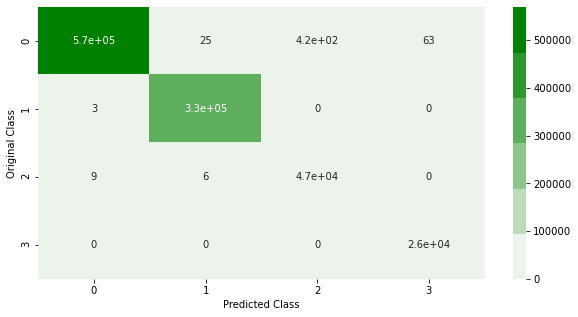

-------------------------------------------------- Precision matrix --------------------------------------------------


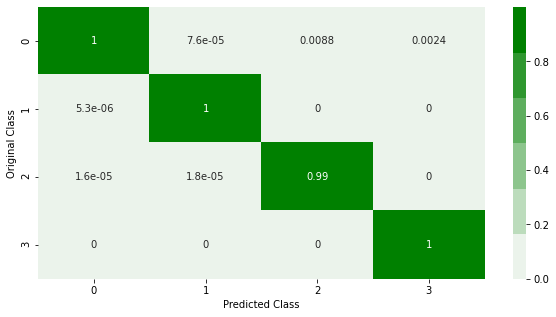

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


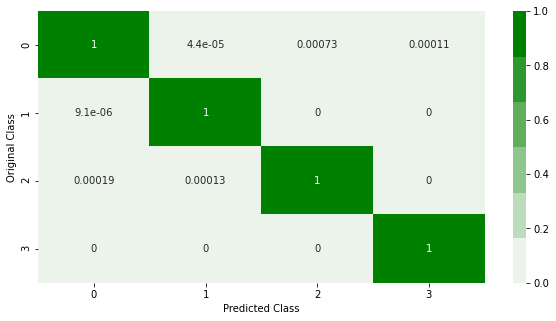

Sum of rows in recall matrix [1. 1. 1. 1.]


In [9]:
plot_confusion_matrix(y_cv, stacking_clf.predict(X_cv))

### Prediction on test dataset

In [ ]:
df_test = dd.read_csv('test.csv')
exp_mapping = {'CA':0, 'DA':1, 'SS':2, 'LOFT':3}
df_test['experiment'] = df_test['experiment'].map(exp_mapping)
df_train['pilot'] = df_train['crew'] * 100 + df_train['experiment'] * 10 + df_train['seat']
test_pilots = [pilot for pilot in df_test['pilot'].unique()]

In [10]:
test_output = []
for pilot in tqdm(test_pilots):
    # Function to generate output for each pilot in given test data
    X_test = pd.read_parquet("test_new_features/"+str(pilot)+".gzip")
    df_pred = pd.DataFrame()
    df_pred['id'] = X_test['id']
    X_test = X_test.drop(['id'], axis=1)
    features = X_test.columns
    crew_ohe = pickle.load(open('crew_ohe.sav','rb'))
    crew_ohe_features = ["crew_"+str(i) for i in crew_ohe.categories_[0]]
    numerical_features = [feature for feature in features if feature not in crew_ohe_features+['seat']]
    scaler = pickle.load(open('scaler.sav', 'rb'))
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])
    X_test = reduce_mem_usage(X_test)
    y_pred = stacking_clf.predict_proba(X_test)
    df_pred['A'] = y_pred[:,0]
    df_pred['B'] = y_pred[:,3]
    df_pred['C'] = y_pred[:,1]
    df_pred['D'] = y_pred[:,2]
    test_output.append(df_pred)

100%|██████████| 18/18 [33:03<00:00, 110.17s/it]


In [11]:
test_output = pd.concat(test_output, ignore_index=True)
test_output.to_csv("stacking_clf_submission.csv", index=False)
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f stacking_clf_submission.csv -m "This output was generated by custom stacking classifier model after tuning for the number and the combination of base models"

100%|███████████████████████████████████████| 1.57G/1.57G [00:14<00:00, 113MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

<img src='https://i.imgur.com/xhfWVQa.png'>

Public Leaderboard rank: 128<br>
Private Leaderboard rank: 133

**Inference:**

The custom stacking classifier does not give a better result than the best generic model